<a href="https://colab.research.google.com/github/sc-dataman/RNN_LSTM/blob/master/GBM_Stock_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

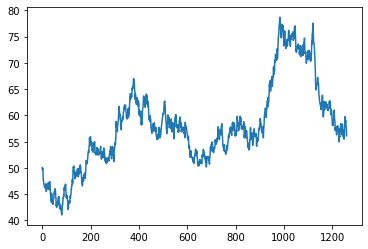

In [1]:
# Recurrent Neural Network



# Part 1 - Data Preprocessing

# Importing the libraries
# Now Create data 
from __future__ import division
from random import gauss
from math import exp, sqrt
from matplotlib import pyplot as plt

def generate_asset_price(S,v,r,T):
    return S * exp((r - 0.5 * v**2) * T + v * sqrt(T) * gauss(0,1.0))

# USER INPUT
S0 = 50 # underlying price
v = 0.20 # vol of 20.76%
mu = 0.02 # mu
dt = 1/252 # 1 day
T = 5 # period end
n = int(T/dt) # number of steps

S_path=[]
S=S0 # starting price
for i in range(1,n+1):
    S_t = generate_asset_price(S,v,mu,dt)
    S= S_t
    S_path.append(S_t)

plt.plot(S_path)


In [5]:
len(S_path)

1260

In [3]:
from dateutil import rrule 
import datetime

# Generate ruleset for holiday observances on the NYSE

def NYSE_holidays(a=datetime.date.today(), b=datetime.date.today()+datetime.timedelta(days=365)):
    rs = rrule.rruleset()

    # Include all potential holiday observances
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=31, byweekday=rrule.FR)) # New Years Day  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, bymonthday= 1))                     # New Years Day  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, bymonthday= 2, byweekday=rrule.MO)) # New Years Day    
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, byweekday= rrule.MO(3)))            # Martin Luther King Day   
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 2, byweekday= rrule.MO(3)))            # Washington's Birthday
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, byeaster= -2))                                  # Good Friday
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 5, byweekday= rrule.MO(-1)))           # Memorial Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 3, byweekday=rrule.FR)) # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 4))                     # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 5, byweekday=rrule.MO)) # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 9, byweekday= rrule.MO(1)))            # Labor Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=11, byweekday= rrule.TH(4)))            # Thanksgiving Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=24, byweekday=rrule.FR)) # Christmas  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=25))                     # Christmas  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=26, byweekday=rrule.MO)) # Christmas 
    
    # Exclude potential holidays that fall on weekends
    rs.exrule(rrule.rrule(rrule.WEEKLY, dtstart=a, until=b, byweekday=(rrule.SA,rrule.SU)))

    return rs
    
# Generate ruleset for NYSE trading days

def NYSE_tradingdays(a=datetime.date.today(), b=datetime.date.today()+datetime.timedelta(days=365)):
    rs = rrule.rruleset()
    rs.rrule(rrule.rrule(rrule.DAILY, dtstart=a, until=b))
    
    # Exclude weekends and holidays
    rs.exrule(rrule.rrule(rrule.WEEKLY, dtstart=a, byweekday=(rrule.SA,rrule.SU)))
    rs.exrule(NYSE_holidays(a,b))
    
    return rs

# Examples

# List all NYSE holiday observances for the coming year
print ("NYSE Holidays\n")
for dy in NYSE_holidays():
    print (dy.strftime('%b %d %Y'))
    

dts = []
# Count NYSE trading days in next 5 years

for yr in range(2015,2020):
  for d in list(NYSE_tradingdays(datetime.datetime(yr,1,1),datetime.datetime(yr,12,31))):
    dts.append(d.strftime('%b %d %Y'))

print(dts)

len(dts)

NYSE Holidays

Apr 10 2020
May 25 2020
Jul 03 2020
Sep 07 2020
Nov 26 2020
Dec 25 2020
Jan 01 2021
Jan 18 2021
Feb 15 2021
['Jan 02 2015', 'Jan 05 2015', 'Jan 06 2015', 'Jan 07 2015', 'Jan 08 2015', 'Jan 09 2015', 'Jan 12 2015', 'Jan 13 2015', 'Jan 14 2015', 'Jan 15 2015', 'Jan 16 2015', 'Jan 20 2015', 'Jan 21 2015', 'Jan 22 2015', 'Jan 23 2015', 'Jan 26 2015', 'Jan 27 2015', 'Jan 28 2015', 'Jan 29 2015', 'Jan 30 2015', 'Feb 02 2015', 'Feb 03 2015', 'Feb 04 2015', 'Feb 05 2015', 'Feb 06 2015', 'Feb 09 2015', 'Feb 10 2015', 'Feb 11 2015', 'Feb 12 2015', 'Feb 13 2015', 'Feb 17 2015', 'Feb 18 2015', 'Feb 19 2015', 'Feb 20 2015', 'Feb 23 2015', 'Feb 24 2015', 'Feb 25 2015', 'Feb 26 2015', 'Feb 27 2015', 'Mar 02 2015', 'Mar 03 2015', 'Mar 04 2015', 'Mar 05 2015', 'Mar 06 2015', 'Mar 09 2015', 'Mar 10 2015', 'Mar 11 2015', 'Mar 12 2015', 'Mar 13 2015', 'Mar 16 2015', 'Mar 17 2015', 'Mar 18 2015', 'Mar 19 2015', 'Mar 20 2015', 'Mar 23 2015', 'Mar 24 2015', 'Mar 25 2015', 'Mar 26 2015', 'Mar 2

1259

In [4]:
S_path = S_path[:len(dts)]
import pandas as pd
df = pd.DataFrame(
    {'Date': dts,
     'Close': S_path
    })
df

,Date,Close
0,Jan 02 2015,50.059896
1,Jan 05 2015,49.663376
2,Jan 06 2015,49.811489
3,Jan 07 2015,49.900222
4,Jan 08 2015,48.011888
...,...,...
1254,Dec 24 2019,59.412298
1255,Dec 26 2019,58.736660
1256,Dec 27 2019,58.958088
1257,Dec 30 2019,57.928405


In [7]:
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%m/%d/%Y')


dcd = df.copy()
print(dcd)

            Date      Close
0     01/02/2015  50.059896
1     01/05/2015  49.663376
2     01/06/2015  49.811489
3     01/07/2015  49.900222
4     01/08/2015  48.011888
...          ...        ...
1254  12/24/2019  59.412298
1255  12/26/2019  58.736660
1256  12/27/2019  58.958088
1257  12/30/2019  57.928405
1258  12/31/2019  57.807408

[1259 rows x 2 columns]


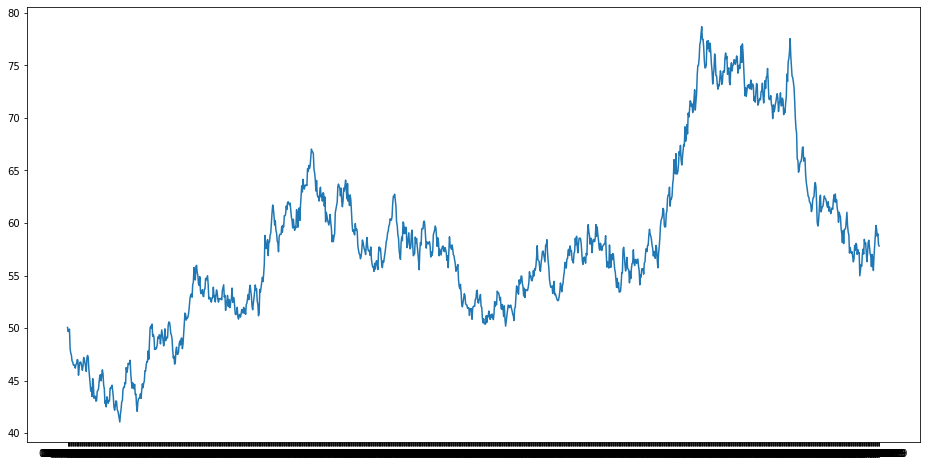

In [8]:
#setting index as date
#df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')


In [9]:
df

,Date,Close
Date,,
01/02/2015,01/02/2015,50.059896
01/05/2015,01/05/2015,49.663376
01/06/2015,01/06/2015,49.811489
01/07/2015,01/07/2015,49.900222
01/08/2015,01/08/2015,48.011888
...,...,...
12/24/2019,12/24/2019,59.412298
12/26/2019,12/26/2019,58.736660
12/27/2019,12/27/2019,58.958088


In [0]:
#importing required libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
dataset = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    dataset['Date'][i] = data['Date'][i]
    dataset['Close'][i] = data['Close'][i]

#setting index
dataset.index = dataset.Date
dataset.drop('Date', axis=1, inplace=True)

train = dataset[0:1239,:]
valid = dataset[1239:,:]


In [0]:
dcd = pd.DataFrame(
    {'Date': dts,
     'Close': S_path
    })
dcd
dcd['Date'] = pd.to_datetime(dcd['Date']).dt.strftime('%m/%d/%Y')

train_dt = dcd[0:1239]
valid_dt = dcd[1239:]


In [45]:
train_dt

,Date,Close
0,01/02/2015,50.059896
1,01/05/2015,49.663376
2,01/06/2015,49.811489
3,01/07/2015,49.900222
4,01/08/2015,48.011888
...,...,...
1234,11/25/2019,57.037886
1235,11/26/2019,58.444293
1236,11/27/2019,57.984133
1237,11/29/2019,58.121490


In [0]:

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [46]:
dataset_train = train_dt.copy()
training_set = dataset_train.iloc[:, 1:2].values #.values is used for creating a numpy array

training_set

array([[50.05989576],
       [49.66337646],
       [49.81148869],
       ...,
       [57.98413251],
       [58.12149022],
       [57.1315717 ]])

In [50]:
training_set

array([[50.05989576],
       [49.66337646],
       [49.81148869],
       ...,
       [57.98413251],
       [58.12149022],
       [57.1315717 ]])

In [0]:

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) #default feature range
"""We have to take new variable and apply fit_transform method from minmax scaler class. Here fit means it is going to
get the min and max of the input data so that it could apply values to the Normalisation formulae. And from that transform method
it is going to compute scaled stock prices for each of the stock prices from the training set according to the Normalisation Formulae"""
training_set_scaled = sc.fit_transform(training_set) 

# Creating a data structure with 60 timesteps and 1 output
"""60 timesteps means that for each time t rnn is going to look at 60 stock prices before time t that is stock prices between 60 days before time t and time t
and based on the trends and correlation it is capturing during the 60 periods time steps it is going to predict the next output."""
X_train = [] # inputs to the NN
y_train = [] # output to the NN
#for i in range(60, 1258): #to populate X_train and y_train
for i in range(60, 1239):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
#Here we are getting 3d structure for X_train by adding third dimension as indicator.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))




In [94]:

# Part 2 - Building the RNN using stacked LSTMs

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

"""Initialising the RNN as a sequence of layers as opposed to computational graphs
here regressor is used because we are predicting continous values."""
regressor = Sequential()

"""Adding the first LSTM layer and some Dropout regularisation
  regressor is an object to sequential class. Sequential class contains add method which is used here.
  Then we add lstm layer using lstm class. 
  It contains three arguments: 1. No of Units/neurons 2.To create stacked(more than 1 layer) LSTM we have to set return_sequences = True
  3. input_shape contains three dimensions no of observations, no of timesteps and no of indicators, here we have taken last two dimensions because first one will
  be automatically considered."""
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#here we are using dropout regularization in order to prevent overfitting in the model.
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')#here loss is mse because we are doing regression here

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 30, batch_size = 16)
"""Since here our dataset is less that's why we have set our epochs = 100, We can also increase no of epochs but it might 
leads to overfitting which is bad for our model."""


Epoch 1/30
1229/1229 [==============================] - 14s 11ms/step - loss: 0.0374
Epoch 2/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0055
Epoch 3/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0056
Epoch 4/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0051
Epoch 5/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0048
Epoch 6/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0043
Epoch 7/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0043
Epoch 8/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0040
Epoch 9/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0042
Epoch 10/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0045
Epoch 11/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0044
Epoch 12/30
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0038

"Since here our dataset is less that's why we have set our epochs = 100, We can also increase no of epochs but it might \nleads to overfitting which is bad for our model."

In [0]:
dataset_train = train_dt
dataset_test = valid_dt

In [0]:

# Prediction on validation data for 20 trading days and visualising the results

# saving the real GBM stock price of last 20 trading days in 2019 

GroundTruth_stock_price = dataset_test.iloc[:, 1:2].values   #converting it into numpy array using .values at end

In [0]:

# Getting the predicted stock price of 2017
"""Here to predict the stock price of particular day we have to take input as a stockprices of previous 60 days.
And while predicting the output some of the stock prices in Jan 2017 have their inputs as the stock prices in test set.
Therefore we have to concatenate both the dataset and forms the total dataset. """
#dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#here we have not used iloc method from pandas to get inputs so here there are chances that we can face format problem so we have to reshape the inputs using reshape function
inputs = inputs.reshape(-1,1)
#scaling the inputs
inputs = sc.transform(inputs)
#loading the X_test list with values for predicting the Jan 2017 stock prices
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#adding third dimension in X_test 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#using predict method for predicting values Using X_test as input values
predicted_stock_price = regressor.predict(X_test)
#inverse_transform method is used for obtaining unscaled/original values.
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


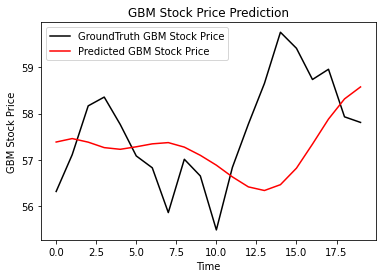

'Here we can see that model can closely predict the trends which are quite similar to the trends in the GBM stock simulated prices. '

In [96]:

# Visualising the results
plt.plot(GroundTruth_stock_price, color = 'black', label = 'GroundTruth GBM Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted GBM Stock Price')
plt.title('GBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GBM Stock Price')
plt.legend()
plt.show()

"""Here we can see that model can closely predict the trends which are quite similar to the trends in the GBM stock simulated prices. """